# Optimize A Multi-agent QA pipeline for HotpotQA Workload

In this example we are building a workflow for [HotpotQA](https://arxiv.org/abs/1809.09600), which requires the agent to retrieve from wiki-2017 documents twice to answer a factorial question.

The implementation is adopted from [dspy](https://github.com/stanfordnlp/dspy?tab=readme-ov-file#5a-dspy-vs-thin-wrappers-for-prompts-openai-api-minichain-basic-templating), including three agents in total:
- **Query agent 0**: generates a search query from the user question.
- **Query agent 1**: refines the search by retrieving additional information based on initial results.
- **Answer agent**: synthesizes the retrieved documents to provide a final answer.

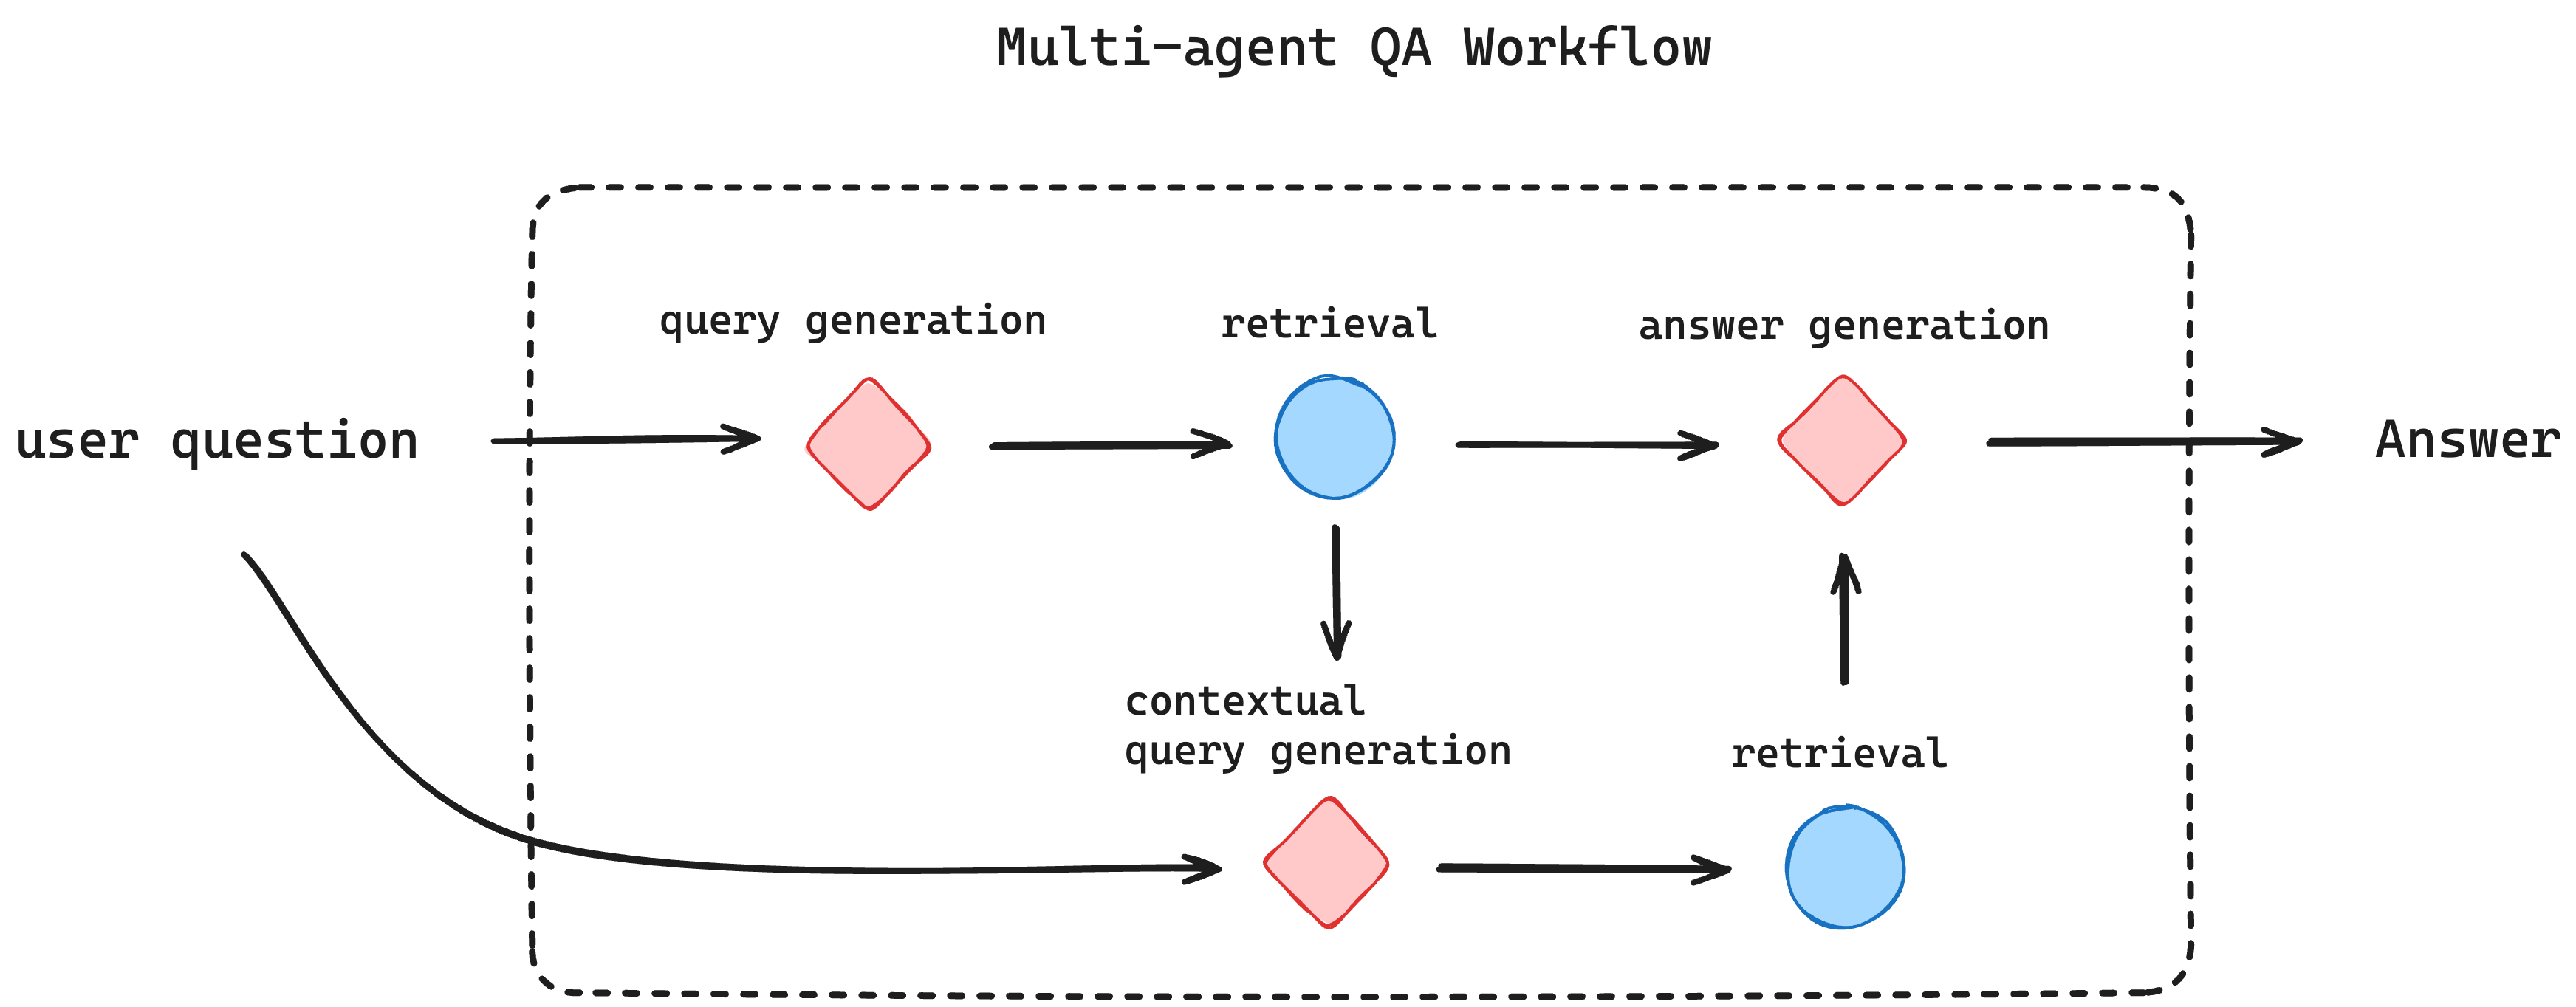

## Setup

First let's set the API key for OpenAI access, you can set that by creating a `.env` file under this directory and add

OPENAI_API_KEY="YOU KEY"

In [1]:
import dotenv

dotenv.load_dotenv()

True

## Define Agents

To specify an agent, we need to 
1. config the model to use
2. define semantic of an agent (it's role, what information it can receive and what output we are expecting from it)


### 1. Set Internal LLM Configuration

In this example we will use 4o-mini for a cheap demonstration

In [2]:
from compiler.llm.model import LMConfig

lm_config = LMConfig(
    custom_llm_provider='openai',
    model='gpt-4o-mini',
    kwargs= {
        'temperature': 0.0,
    }
)

### 2. Define Agent Semantic

Our query agent 0 will receive user `question` and generate a `search_query`. 

Also to avoid the agent giving more text other than the query itself, we can explicitly add output instructions to enforce this rule.

In [3]:
from compiler.llm import CogLM, InputVar, OutputLabel

initial_query_prompt = """
You are an expert at crafting precise search queries based on a provided question. Your sole task is to generate a detailed and well-structured search query that will help retrieve relevant external documents containing information needed to answer the question.

You should not answer the question directly, nor assume any prior knowledge. Instead, focus on constructing a search query that explicitly seeks external sources of information and considers the question's key elements, context, and possible nuances. Think carefully about the implications of your search and ensure that the search query encapsulates the key elements needed to retrieve the most pertinent information.
"""
first_query_agent = CogLM(agent_name="generate_query",
                          system_prompt=initial_query_prompt,
                          input_variables=[InputVar(name="question")],
                          output=OutputLabel(name="search_query", custom_output_format_instructions="Output only the search query, without any prefixes, or additional text."),
                          lm_config=lm_config)

Let's try out this agent with a simple question.

Currently you can convert this into a Langchain Runnable to easily integrate into your current Langchain/Langgraph program.

In [19]:
from compiler.frontends.langchain.connector import as_runnable

dummy_question = 'What was the 2010 population of the birthplace of Gerard Piel?'
first_query_agent_runnable = as_runnable(first_query_agent)
search_query = first_query_agent_runnable.invoke({'question': dummy_question}) # the result will be an Langchain AIMessage
search_query.content

'"2010 population birthplace of Gerard Piel"'

You can also query the agent using OpenAI-style messages.

In [ ]:
messages = [{"role": "user", "content": f"{dummy_question}"}]
response = first_query_agent.forward(messages, inputs={'question': dummy_question})
response.choices[0].message.content

### 3. Now Let's define the reset two agents

Second query generation agent that is conditioned on the retrieved context.

In [11]:
following_query_prompt = """
You are good at extract relevant details from the provided context and question. Your task is to propose an effective search query that will help retrieve additional information to answer the question. Think carefully about the implications of your search. The search query should target the missing information while avoiding redundancy. 

You should not answer the question directly, nor assume any prior knowledge. You must generate an accurate search query that considers the context and question to retrieve the most relevant information.
"""

following_query_agent = CogLM(agent_name="refine_query",
                          system_prompt=following_query_prompt,
                          input_variables=[InputVar(name="context"), InputVar(name="question")],
                          output=OutputLabel(name="search_query", custom_output_format_instructions="Output only the search query, without any prefixes, or additional text."),
                          lm_config=lm_config)

Final answer generation agent

In [14]:
answer_prompt = """
You are an expert at answering questions based on provided documents. Your task is to formulate a clear, accurate, and concise answer to the given question by using the retrieved context (documents) as your source of information. Please ensure that your answer is well-grounded in the context and directly addresses the question.
"""
answer_agent = CogLM(agent_name="generate_answer",
                     system_prompt=answer_prompt,
                     input_variables=[InputVar(name="context"), InputVar(name="question")],
                     output=OutputLabel(name="answer", custom_output_format_instructions="Output the answer directly without unnecessary details, explanations, or repetition."),
                     lm_config=lm_config)

### 4. With all these agents, let's create the final multi-agent pipeline

Since the original workflow is in `dspy`, let's call `as_predict()` around our agents to easily integrate them into the original workflow.

In [20]:
import dspy
from dsp.utils.utils import deduplicate
colbert = dspy.ColBERTv2(url='http://192.168.1.16:8893/api/search') # replace this with your own ColBERT server
dspy.configure(rm=colbert)

In [29]:
from compiler.frontends.dspy.connector import as_predict

class BasicQA(dspy.Module):
    def __init__(self, passages_per_hop=3):
        super().__init__()

        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.initial_generate_query = as_predict(first_query_agent)
        self.follwing_generate_query = as_predict(following_query_agent)
        self.generate_answer = as_predict(answer_agent)
    
    def doc_str(self, context):
        docs = []
        for i, c in enumerate(context):
            docs.append(f"[{i+1}]: {c}")
        return "\n".join(docs)

    def forward(self, question):
        context = []

        search_query = self.initial_generate_query(question=question).search_query
        # Incase the query is multiline, flatten it
        search_query = search_query.replace("\n", ". ")
        passages = self.retrieve(search_query).passages
        context = deduplicate(context + passages)
        
        for _ in range(2-1):
            search_query = self.following_generate_query(context=self.doc_str(context), question=question).search_query
            # avoid only searching the first line
            search_query = search_query.replace("\n", ". ")
            passages = self.retrieve(search_query).passages
            context = deduplicate(context + passages)
        answer = self.generate_answer(context=self.doc_str(context), question=question).answer
        return answer

In [30]:
pipeline = BasicQA(passages_per_hop=2)
pipeline(dummy_question)

'17,121'

## Optimize The Workflow

We will walk through step by step how the optimizer is configured and invokved. 


### 1. Prepare the Dataset for Optimization in `data_loader.py`

We first define a function that returns the (input/output) pair for the optimizer to use. These variables will be used in the following way:

1. prediction = your_workflow(input)
2. score = your_evaluator(output, prediction)

The optimizer will directly forward the input/output/prediction. If your evaluator does not need a ground truth, e.g. some LLM judge, you can return None for the output.

In [38]:
from compiler.optimizer.registry import register_data_loader
from dspy.datasets.hotpotqa import HotPotQA

@register_data_loader
def load_data():
    dataset = HotPotQA(train_seed=1, train_size=150, eval_seed=2023, dev_size=200, test_size=0)
    def get_input_label(x):
        return x.question, x.answer
    trainset = [get_input_label(x) for x in dataset.train[0:100]]
    valset = [get_input_label(x) for x in dataset.train[100:150]]
    devset = [get_input_label(x) for x in dataset.dev]
    return trainset, valset, devset

### 2. Tell Optimizer How to Evaluate the Pipeline in `cognify_anno.py`

Our design principle is to give user the utmost freedom to craft their pipeline, e.g. you are free to use any kinds of global variables.

We will save the pipeline into a file with two additional annotation. The optimizer will evaluate the pipeline in separate process for each input to ensure correctness.

#### > Register the workflow entry point to optimizer

The entry point will be invoked with input from the dataloader, in this example, a question string.

In [34]:
from compiler.optimizer import register_opt_program_entry, register_opt_score_fn

@register_opt_program_entry
def do_qa(question: str):
    answer = pipeline(question=question)
    return answer

#### > Register the evaluation function

This will be invoked with ground truth and the pipeline output

In [36]:
from dsp.utils.metrics import F1

@register_opt_score_fn
def answer_f1(label: str, pred: str):
    if isinstance(label, str):
        label = [label]
    score = F1(pred, label)
    return score

### 3. Config the Optimizer

Here we show a simplified configuration.

We will define our settings in a python file, wherein we create a `ControlParameter` to shape the behavior of optimizer.

There are three core components that need to be concerned:

1. *Parameter* - the variable that need to be optimized by Cognify
2. *Option* - the value that is available in each parameter
3. *Layer* - the logical separation of parameters

#### 3.1 Layered Optimization



We will walk though the given `control_param.py` in this example

#### 3.1 Define Inner Loop Configuration

At this layer we optimize the reasoning style and few-shot examples for all LLM agents

This layer will run for 6 trials (each trial tries one combination of all parameters)

In [1]:
from compiler.optimizer.core import driver, flow
from compiler.optimizer.params import reasoning, fewshot, common

# NoChange is an option that does nothing, 
# NOTE: we don't include this by default incase you always want to choose from a specific set of options
nop = common.NoChange()

# Reasoning Parameter and its options
reasoning_param = reasoning.LMReasoning(
    [nop, reasoning.ZeroShotCoT()]
)

# Few Shot Paratemter
# NOTE: we don't require demonstrations from user
# options will be generated during the optimization process as the final quality is improving
# Here we just set the number of few-shot examples to 4
few_shot_params = fewshot.LMFewShot(4)

# Layer Config
# NOTE: We register the parameter to universal_params, 
# which indicates that all LLM agents will need to tune their reasoning and few-shot examples
# Please check the document if you want more fine-grained control
inner_opt_config = flow.OptConfig(
    n_trials=6,
)
inner_loop_config = driver.LayerConfig(
    layer_name='inner_loop',
    universal_params=[few_shot_params, reasoning_param],
    opt_config=inner_opt_config,
)

/mnt/ssd4/lm_compiler/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 3.2 Define Outer Loop Configuration

At this layer we optimize the ensembling method for all LLM agents. 

We add a self-consistency option from [paper](https://arxiv.org/abs/2311.17311), in which multiple independent agents will be spawned to propose their answer and leverage another LLM to synthesize the final response.

Similarly we set the outer loop optimization. This layer will have `4` iterations, each trial will invoke an inner-loop routine that we defined above to perform the optimization. So in total this setting will evaluate `4x6` parameter configurations in total.

In [ ]:
from compiler.optimizer.params import ensemble

# Ensemble Parameter
# An agent now may spawn 3 workers to propose the answer and have another LLM choose the best one
# These spawned workers will also be optimized in the inner loop
general_usc_ensemble = ensemble.UniversalSelfConsistency(3)
general_ensemble_params = ensemble.ModuleEnsemble(
    [nop, general_usc_ensemble]
)
# Layer Config
outer_opt_config = flow.OptConfig(
    n_trials=4,
)
outer_loop_config = driver.LayerConfig(
    layer_name='outer_loop',
    universal_params=[general_ensemble_params],
    opt_config=outer_opt_config,
)